### Libraries Import

In [1]:
import time
import tabulate

import matplotlib
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15,15)

### Load Data

Data came from `sklearn` datasets. For the sake of visualization we will use 2 features from this data set. What they mean is irrelevant to us. 

In [2]:
full_data = datasets.load_diabetes()
one_feature = full_data.data[:, np.newaxis, 2]

x_training = one_feature[:-100]
y_training = full_data.target[:-100]

x_testing = one_feature[-100:]
y_testing = full_data.target[-100:]

### Plot
Plot the initial data `<x, y>`.

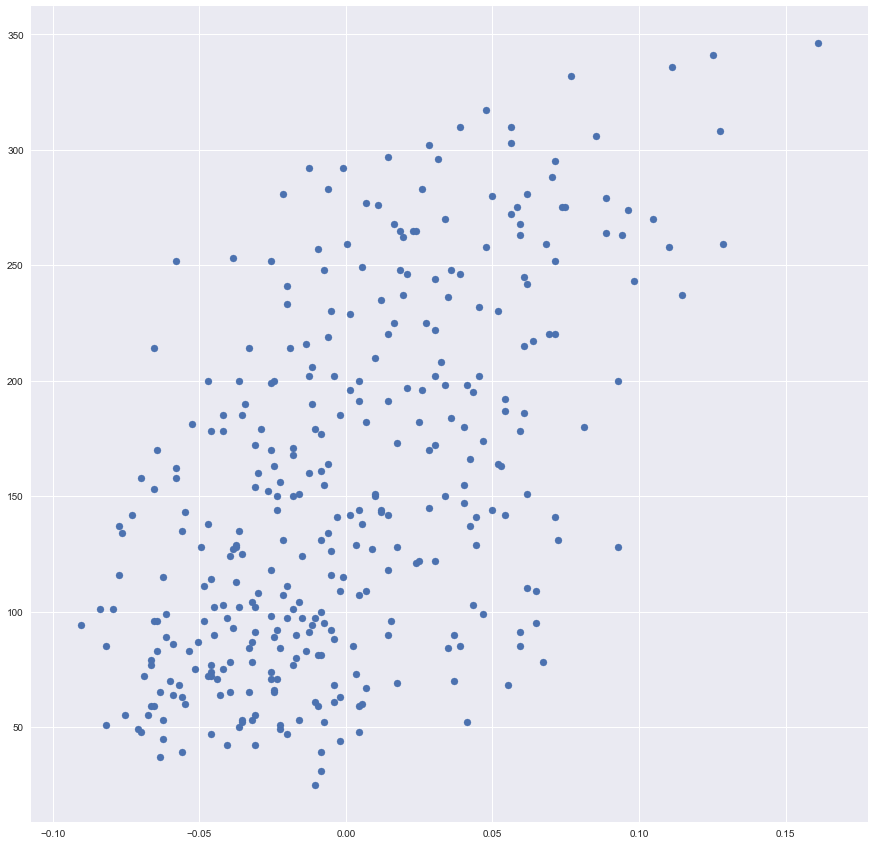

In [3]:
plt.scatter(x_training, y_training)

# Linear Regression: Ordinary Least Squares

In [4]:
def ordinary_least_squares(x, y):
    '''
    Find weights for hypothesis of the form:
        w*x + b
    using ordinary leasts squares method where
    w defined as b0, b as b1 by convention.
    
    Params:
        x: training data values
        y: training data lables
    
    Returns:
        hypothesis function
    '''    
    xmean = np.mean(x)
    ymean = np.mean(y)

    m = len(x)
    
    numerator = 0
    denominator = 0

    for i in range(m):
        numerator += (x[i] - xmean) * (y[i] - ymean)
        denominator += (x[i] - xmean)**2
    
    b1 = numerator / denominator
    b0 = ymean - (b1 * xmean)
    
    # b1 and b0 are np arrays -> extract their actual values
    b = b0[0]
    w = b1[0]
    
    return lambda x: w*x + b

### Create a Hypothesis

`ordinary_least_squares` returns a lambda function which represents a hypothesis, so we can use it like a `f(x)` math function.

In [5]:
hypothesis = ordinary_least_squares(x_training, y_training)

### Make a Prediction

In [6]:
prediction = hypothesis(x_training)
prediction = prediction.reshape((342,))

### Plot Data and Linear Regression

It is easy to verify approximate correctness of an algorithm if line is right in the middle of the data.

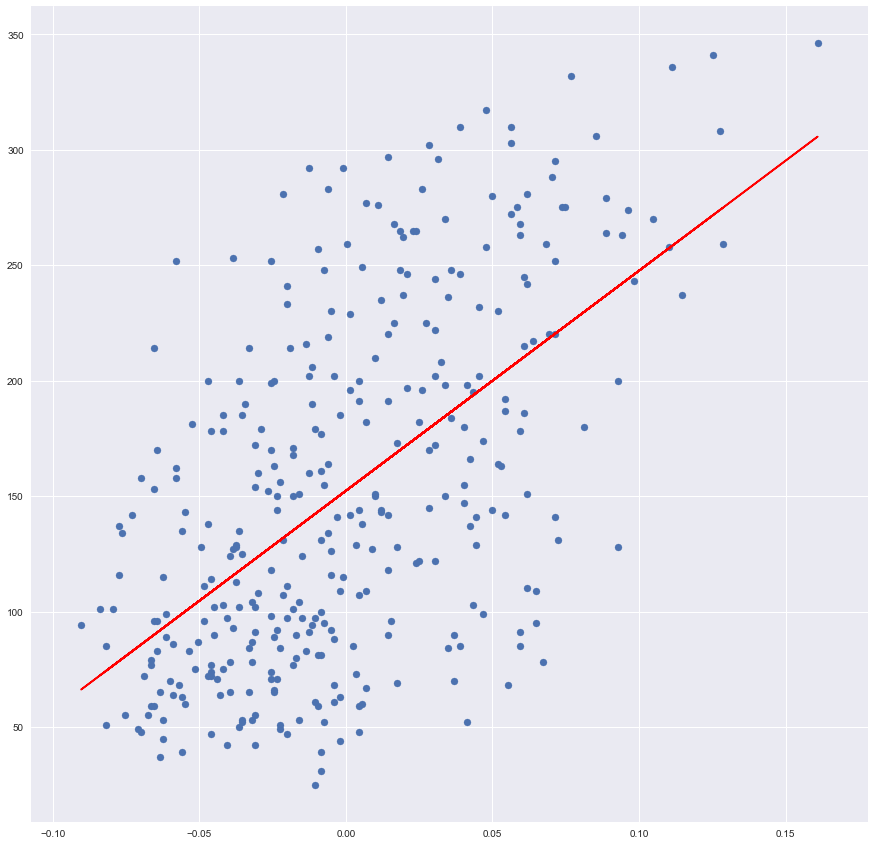

In [7]:
plt.scatter(x_training, y_training)
plt.plot(x_training, prediction, color='red')

### Verify

Lets take `LinearRegression` from `sklearn` as an ethalon implementation and compare results with our custom solution. 

In [8]:
model = linear_model.LinearRegression()
model.fit(x_training, y_training)
sk_prediction = model.predict(x_training)

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


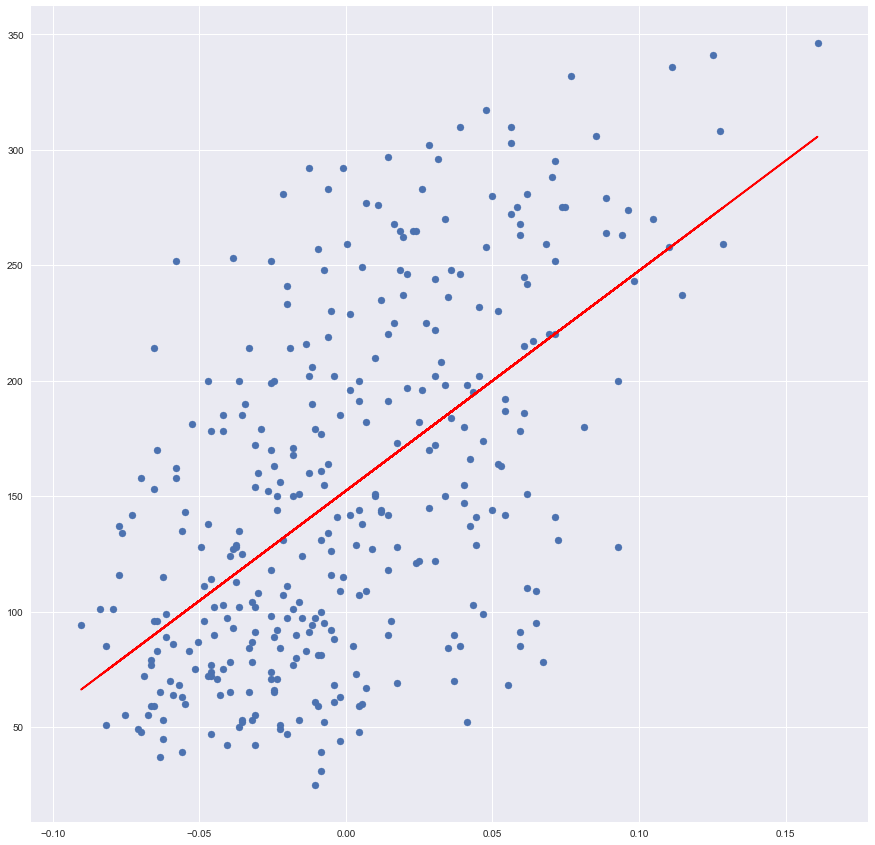

In [9]:
plt.scatter(x_training, y_training)
plt.plot(x_training, sk_prediction, color='red')

### Implement an Evaluator

Mean squared error implementation.

In [10]:
def mean_squared_error_custom(truth, predicted):
    m = truth.shape[0]
    mse = (np.sum((predicted - truth)**2)) / m
    return mse

### Compare

Compare custom linear regression implementation and one from `sklearn`. So far plots are looking the same, but what about numbers?

In [11]:
print(mean_squared_error_custom(y_training, sk_prediction))
print(mean_squared_error_custom(y_training, prediction))

3930.78755528
3930.78755528


The result is the same, therefore implementation is correct.


---


# Batch Gradient Descent


Lets prepare the data and buid:

* `X` is a feature array with built-in bias
* `w` initialization for weights
* `y` ground truth

In [12]:
x1 = full_data.data[:, np.newaxis, 1]
x1 = np.squeeze(np.asarray(x1[:-100]))

x2 = full_data.data[:, np.newaxis, 2]
x2 = np.squeeze(np.asarray(x2[:-100]))

ones = np.ones(len(x1))

X = np.array([ones, x1, x2]).T
y = full_data.target[:-100]

### Implementation

In [13]:
def batch_gradient_descent(X, y, lrate, niter):
    weights = np.array([0, 0, 0])
    history = []
    m = len(y)
    
    for i in range(niter):
        h = X.dot(weights)
        loss = h - y
        gradient = X.T.dot(loss) / m
        weights = weights - lrate*gradient
        cost = mean_squared_error_custom(X.dot(weights), y)
        
        if i % 50 == 0:
            history.append(cost)

    return weights, history

### Optimize Weights

In [14]:
learned, history = batch_gradient_descent(X, y, 0.05, 20000)

### Plot Training History

History was written by `batch_gradient_descent` each 50 iterations. Each history entry is a value for a `cost_function`.

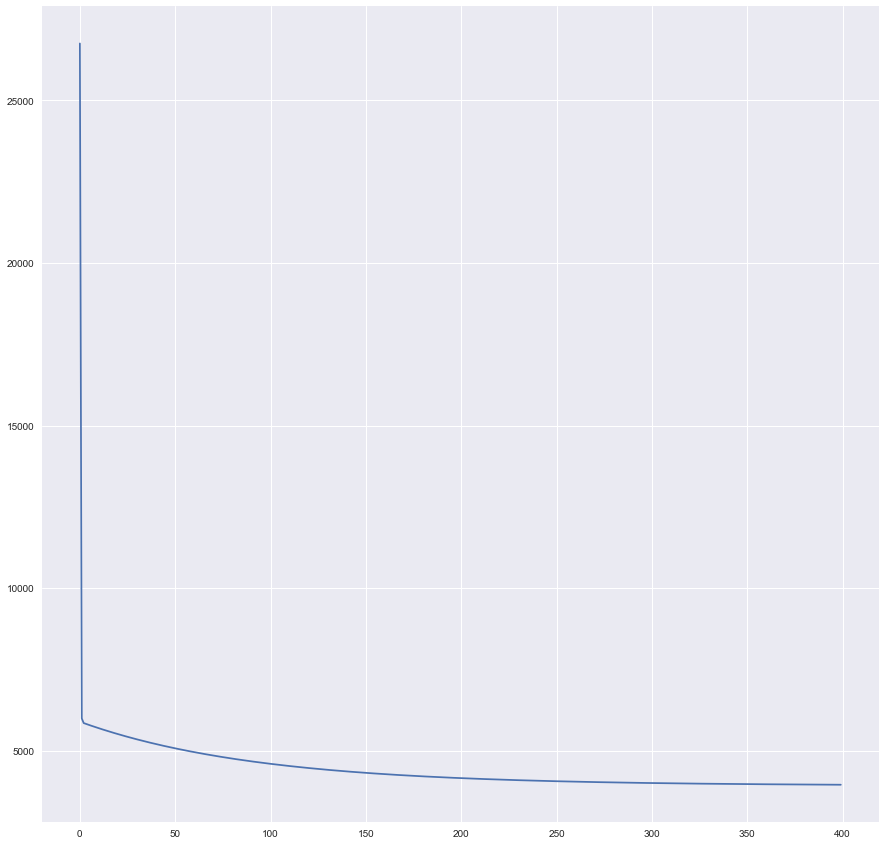

In [15]:
plt.plot(history)

### Make a Prediction and Get a Mean Squared Error

In [16]:
gds_predictions = X.dot(learned)
err = mean_squared_error_custom(gds_predictions, y)

print(err)

3954.91418574


### Validate

Validate the result of the custom BGD with running the same routine using `sklearn`.

In [17]:
sk_reg = linear_model.LinearRegression()
sk_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
sk_reg_pred = sk_reg.predict(X)

In [19]:
mean_squared_error(sk_prediction, y)

3930.7875552792716

We can se that mean square error is kind of similar. This is happened because BGD has hyperparameters which can be tuned and edited, while OLS has no hyperparameters, therefore output is always the same.


---

# Hyperparameters

Lets observe *how* hyperparameters affects our algorithm.

In `lrates` we define various values for learning rate hyperparameter, and in `niterations` various values for number of iterations hyperparamenters.

Methodology looks as the following: we will run Batch Gradient Descent with each possible combination of hyperparameters and compare them in multiple ways.

In [20]:
lrates = [.5, .1, .01, .001, .0001]
niterations = [25000, 50000, 150000]

`test` function iterates over each hyperparameter and put all the results in record list.

In [21]:
def test(X, y):
    record = []
    
    for niter in niterations:
        for lrate in lrates:
            start = time.time()
            weigths, records = batch_gradient_descent(X, y, lrate, niter)
            delta = time.time() - start
            record.append(dict(lrate=lrate, niter=niter, w=weigths, history=records, time=delta))
    
    return record

In [22]:
rec = test(X, y)

### Plot

Lets plot all the GBD histories

In [23]:
def plot_records(records):
    for record in records:
        label = 'lr: {0}, ni: {1}, t: {2}'.format(record["lrate"], record["niter"], record["time"])
        plt.plot(record['history'], label=label)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

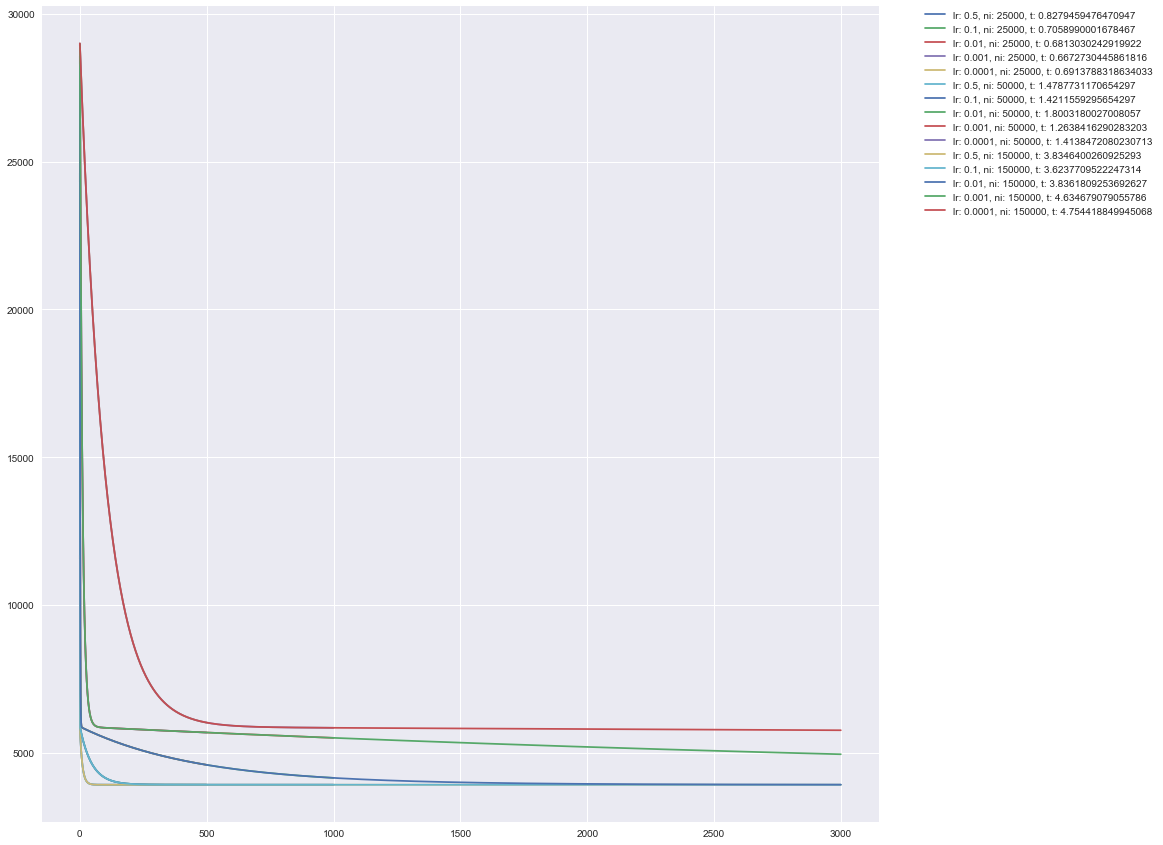

In [24]:
plot_records(rec)

Actually this plot is not any good for now because we can not read the data from it. However we can observe that there is a difference indeed.

### Plot: Take 2

First plot didn't work out well, lets plot each BGD individually.

In [25]:
def plot_records(records):
    name_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O'}
    figure, plots = plt.subplots(5, 3)
    figure.tight_layout()
    plots = plots.flatten()
    for i, record in enumerate(records):
        time = "{0:.4f}".format(record['time'])
        label = 'lr: {0}, ni: {1}, t: {2}'.format(record["lrate"], record["niter"], time)
        plots[i].plot(record['history'], label=label) 
        plots[i].legend(loc='upper right')
        plots[i].set_title(name_map[i])

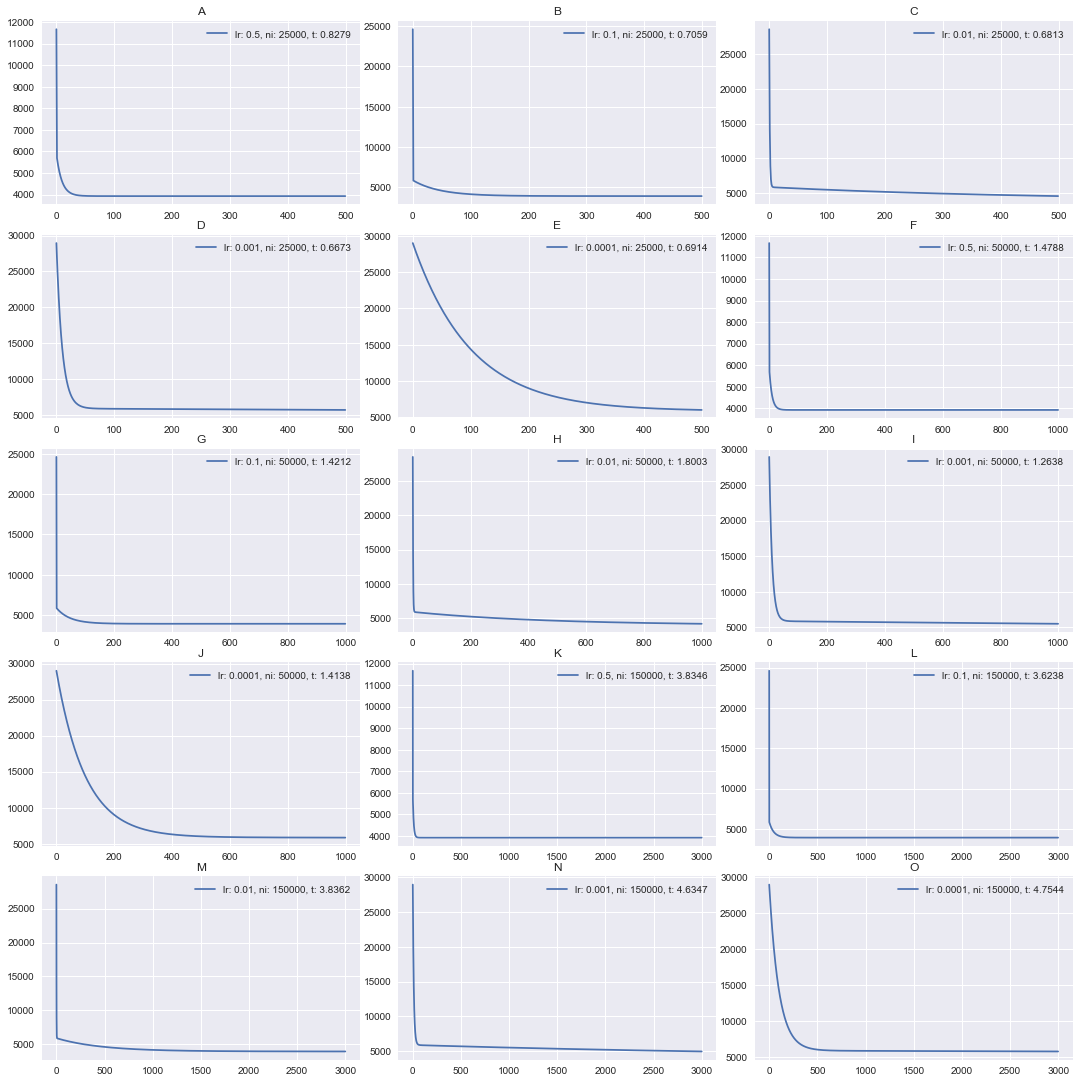

In [26]:
plot_records(rec)

### More Data

Plot from above is good and clear, lets print the data out as a table.

First prepare the data, sort it by time and print.

In [27]:
srec = sorted(rec, key=lambda k: k['time']) 

In [28]:
tab_data = srec.copy()

In [29]:
for r in tab_data:
    r['cost'] = r['history'][-1]
    del r['history']
    del r['w']

In [30]:
print(tabulate.tabulate(srec, headers={'lrate': 'lrate', 'niter': 'niter', 'time': 'elapsed time', 'cost': 'cost'}))

  lrate    niter    elapsed time     cost
-------  -------  --------------  -------
 0.001     25000        0.667273  5692.25
 0.01      25000        0.681303  4599.48
 0.0001    25000        0.691379  6029.03
 0.1       25000        0.705899  3926.99
 0.5       25000        0.827946  3926.93
 0.001     50000        1.26384   5511.89
 0.0001    50000        1.41385   5852.02
 0.1       50000        1.42116   3926.93
 0.5       50000        1.47877   3926.93
 0.01      50000        1.80032   4158.42
 0.1      150000        3.62377   3926.93
 0.5      150000        3.83464   3926.93
 0.01     150000        3.83618   3930.42
 0.001    150000        4.63468   4957.71
 0.0001   150000        4.75442   5769.71


Data is sorted by time because I choosed this parameter as most important. Generally we want to compute as fast as possible while result is sufficiently good.

We can see that generally that cost `3926.93` can be considered as **converged**.

In our case, *with a given data*, learning rate of `.5` converged after `25000` iterations, while learning rate of `.0001` has a long way to go until convergence.

Lets actually see how many iterations it need to converge:

In [31]:
weights_t, records_t = batch_gradient_descent(X, y, 0.0001, 2000000)
print(records_t[-1])

4758.47004944


Even after `2,000,000` iterations GBD with learning rate of `.0001` converged to cost of `4758.47`, which is comparable result to `<.01, 25,000>` hyperparameter pair.